In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

from ipynb.fs.full.common import *

In [2]:
# load gameplays
gameplays = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\gameplays.json").readlines()).apply(json.loads))

In [3]:
# gameplay columns
# gameplays.columns

In [4]:
# load questionresponses and expand the response columns to contain "lastentry" and "secondlastentry" instead of 'A', 'B' or 'BOTH'
questionresponses = pd.json_normalize(pd.Series(open(r"C:\Users\Yasmine Bogaert\Documents\thesis\dump\dump_30-03-2021\csv\questionresponses.json").readlines()).apply(json.loads))

questionresponses = expand_questionresponses(questionresponses)
questionresponses

,secondlastentry,lastentry,fun,challenging,frustrating,time,USERID,_id.$oid
0,5fb6e066578328c98e6322cf,5fb6e45fb472c8cc964ed7b7,lastentry,lastentry,secondlastentry,22819.465,6597767d-39cf-406d-91aa-c978e9692138,5fb6e479b472c8cc964ed7b8
1,5fb6e320578328c98e6322d0,5fb6efe9b472c8cc964ed7b9,secondlastentry,lastentry,"[secondlastentry, lastentry]",3501.885,4973e61c-c96c-47a0-bbc8-6671d7480341,5fb6eff0b472c8cc964ed7ba
2,5fb7e437b472c8cc964ed7bc,5fb7e442b472c8cc964ed7bd,lastentry,lastentry,lastentry,6717.495,8284f581-eb66-4c8b-95ce-16b161b68e2a,5fb7e44bb472c8cc964ed7be
3,5fb7ed35b472c8cc964ed7bf,5fb7ed58b472c8cc964ed7c0,lastentry,neither,neither,19231.370,8b17c68b-e9ff-454c-80c0-41baea4bb272,5fb7ed6eb472c8cc964ed7c1
4,5fb7eeb8b472c8cc964ed7c2,5fb7eeebb472c8cc964ed7c3,lastentry,secondlastentry,secondlastentry,11961.000,c6291e5d-f5f6-4ed7-b403-818ec9814067,5fb7eefab472c8cc964ed7c4
...,...,...,...,...,...,...,...,...
518,605214f21066e2827b2a39ec,6052152e1066e2827b2a39ed,lastentry,lastentry,secondlastentry,11938.165,b565c9e2-fcb8-4d63-acdb-b43ca628ef71,6052153d1066e2827b2a39ee
519,6052175d1066e2827b2a39ef,605217731066e2827b2a39f0,lastentry,lastentry,secondlastentry,6981.965,b1dbb85d-bdee-436e-b781-e869d7c86a3f,6052177d1066e2827b2a39f1
520,605217731066e2827b2a39f0,605217c61066e2827b2a39f2,secondlastentry,secondlastentry,lastentry,7266.165,b1dbb85d-bdee-436e-b781-e869d7c86a3f,605217d01066e2827b2a39f3
521,605625cd1066e2827b2a39fa,605626261066e2827b2a39fb,secondlastentry,secondlastentry,secondlastentry,78137.420,8acb006d-f5e4-467f-8873-ea12705524eb,605626781066e2827b2a39fc


In [5]:
# top 3 highest scores before preprocessing
# we see some high scores with unrealistic corresponding amount of jumps
gameplays[['actualDistance', 'nr_jumps']].nlargest(3, 'actualDistance')

,actualDistance,nr_jumps
782,20005,2
909,10598,529
1050,10245,5


In [6]:
# top 3 highest scores after preprocessing
gameplays = preprocess_gameplays(gameplays)
gameplays[['actualDistance', 'nr_jumps']].nlargest(3, 'actualDistance')

,actualDistance,nr_jumps
211,4850,321
840,4667,201
1007,4379,173


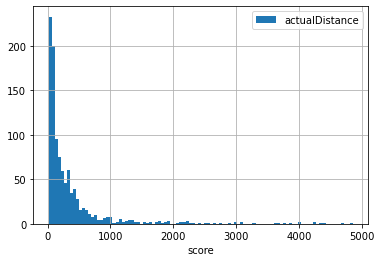

In [7]:
### Score distribution
ax = gameplays["actualDistance"].hist(bins=100, legend=True)
ax.set_xlabel("score")
plt.savefig('graphs/notebook/score_distribution.png')

In [8]:
def count_piechart(collection, column):
    counts = collection[column].groupby(collection[column]).count()
    labels = []
    for type_ in counts.index:
        percentage = "%.2f" % (counts[type_]/counts.sum()*100)
        labels.append(str(type_) + "\n" + str(percentage) + "%")
    labels

    p = plt.pie(counts, labels=labels)

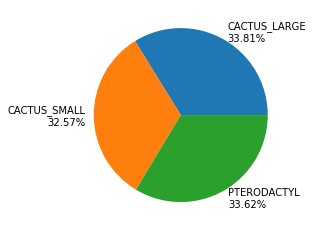

In [9]:
# What obstacle do players collide with upon dying?

count_piechart(gameplays, "collisionObstacle.typeConfig.type")
plt.savefig('graphs/notebook/collisionObstacle_pie.png')

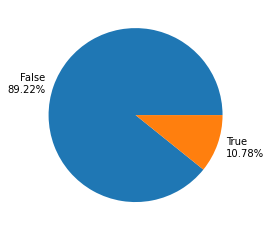

In [10]:
# Do players die during nightmode (when nightmode is enabled)? 

coll = gameplays.loc[gameplays["parameters.NIGHT_MODE_ENABLED"] == True]
count_piechart(coll, "invertedGameOver")

plt.savefig('graphs/notebook/invertedGameOver_pie.png')

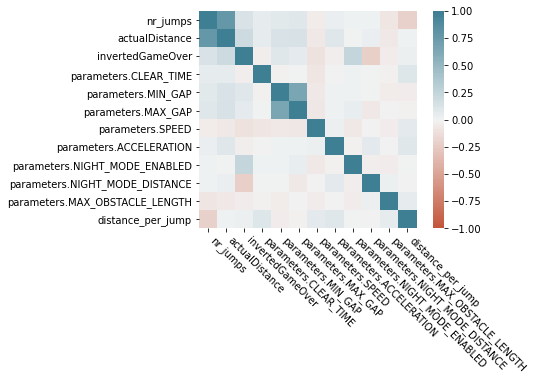

In [11]:
# Are there any correlations between these relevant columns?
# actualDistance (score)  ~  nr_jumps 
# night_mode enabled      ~  invertedGameOver

gameplays = add_distance_per_jump(gameplays)

corr = gameplays[["nr_jumps", "actualDistance", "invertedGameOver", "parameters.CLEAR_TIME", "parameters.MIN_GAP", 'parameters.MAX_GAP',  "parameters.SPEED", "parameters.ACCELERATION", 'parameters.NIGHT_MODE_ENABLED', 'parameters.NIGHT_MODE_DISTANCE','parameters.MAX_OBSTACLE_LENGTH',  "distance_per_jump" ]].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=-45,
    horizontalalignment='left'
);

plt.savefig('graphs/notebook/gameplays_heatmap.png')

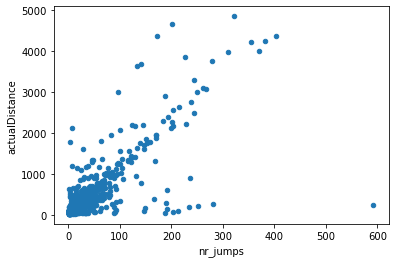

In [12]:
# actualDistance (score)  ~  nr_jumps 
# linear, a few outliers

gameplays.plot(x="nr_jumps", y="actualDistance", kind="scatter")

plt.savefig('graphs/notebook/scatter_jumps_score.png')

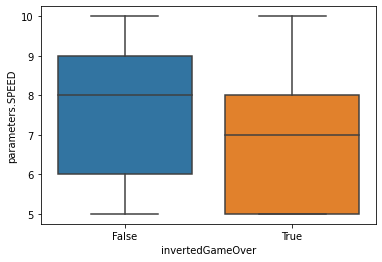

In [13]:
# Does speed have an effect on when players die during night mode?
# todo: filter out only games where night mode is enabled

coll = gameplays.loc[gameplays["parameters.NIGHT_MODE_ENABLED"] == True]
sns.boxplot(y=coll['parameters.SPEED'], x=coll['invertedGameOver'])

plt.savefig('graphs/notebook/boxplot_invertedGameOver_speed.png')

<AxesSubplot:ylabel='actualDistance'>

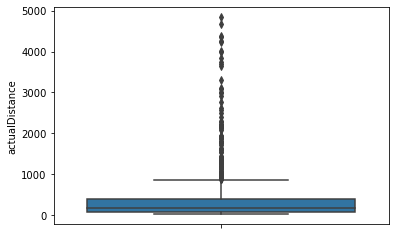

In [14]:
sns.boxplot(y=gameplays['actualDistance'])

<AxesSubplot:ylabel='actualDistance'>

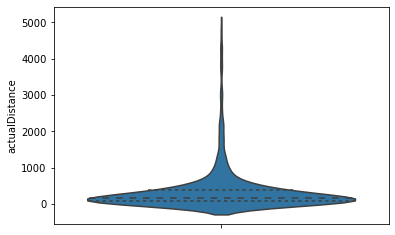

In [15]:
sns.violinplot(y=gameplays['actualDistance'],  inner="quartile")

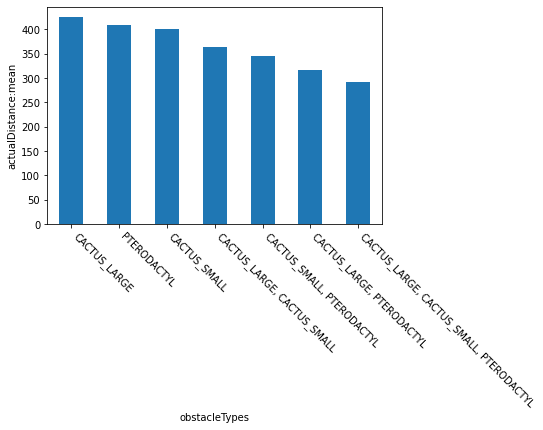

In [16]:
# mean score per obstacleTypes config
# -> get a feeling of difficulty per 'rank'

def normalize_obstacleType(entries):
    return ', '.join([obstacleType['type'] for obstacleType in entries])
normalized_obstacleTypes = gameplays["obstacleTypes"].apply(normalize_obstacleType)
#print(normalized_obstacleTypes)
group_means = gameplays["actualDistance"].groupby(normalized_obstacleTypes).mean().sort_values(ascending=False)
#print(group_means)

ax = group_means.plot(kind="bar")
# rotate x labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=-45,
    horizontalalignment='left'
);
ax.set_ylabel("actualDistance:mean")
ax

plt.savefig('graphs/notebook/bar_obstacleTypes_spec_mean_score.png')